`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Boston_for_lab` (источник: <https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv>)

# Указания к выполнению


## Загружаем пакеты

In [19]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [20]:
# константы
#  ядро для генератора случайных чисел
my_seed = 24
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Boston_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [21]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [22]:
# первые 5 строк фрейма
DF_raw.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


Здесь:
* **crim**– уровень преступности на душу населения по району;
* **zn**– доля земли под жилую застройку;
* **indus**– доля акров, не связанных с розничной торговлей, на город;
* **chas**– ;
* **nox**– концентрация оксидов азота (частей на 10 миллионов);
* **rm**– среднее количество комнат в доме;
* **age**– возраст;
* **dis**– средневзвешенное расстояние до пяти бостонских центров занятости;
* **rad**– ;
* **tax**– ;
* **ptratio**– ;
* **black**– ;
* **lstat**– ;
* **medv**– медианная стоимость домов, тыс. долл. США;
* **tax_over_400**– полная ставка налога на имущество на $10000 больше 400 (0-нет;1-да).

In [23]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [24]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков не обнаружено.  

In [25]:
# находим уникальные medv
DF_raw['rad'].unique()

array([ 1,  2,  3,  5,  4,  8,  6,  7, 24], dtype=int64)

In [26]:
#  добавляем фиктивные на регион: число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['rad']], drop_first=True)
df_dummy.head(5)

,rad
0,1
1,2
2,2
3,3
4,3


In [27]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(506, 16)

In [28]:
# смотрим первые 8 столбцов
DF_all.iloc[:, :8].head(5)

,crim,zn,indus,chas,nox,rm,age,dis
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622


In [29]:
# смотрим последние 8 столбцов
DF_all.iloc[:, 8:].head(5)

,rad,tax,ptratio,black,lstat,medv,tax_over_400,rad
0,1,296,15.3,396.90,4.98,24.0,0,1
1,2,242,17.8,396.90,9.14,21.6,0,2
2,2,242,17.8,392.83,4.03,34.7,0,2
3,3,222,18.7,394.63,2.94,33.4,0,3
4,3,222,18.7,396.90,5.33,36.2,0,3


In [30]:
# оставляем в наборе данных только то, что нужно
DF_all = DF_all[['medv', 'rm', 'indus', 'tax_over_400']]

class_le = LabelEncoder()
DF_all['medv'] = class_le.fit_transform(DF_all.medv.values)

DF_all.columns

Index(['medv', 'rm', 'indus', 'tax_over_400'], dtype='object')

In [31]:
DF_all.dtypes

medv              int64
rm              float64
indus           float64
tax_over_400      int64
dtype: object

In [32]:
# удаляем фрейм-исходник
del DF_raw

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [33]:
# данные для построения моделей
DF = DF_all.sample(frac = 0.8, random_state = my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `medv`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `tax_over_400` принимает нулевые значения. Остальные показатели положительны.  

In [34]:
# описательные статистики для непрерывных переменных
DF[['medv', 'rm', 'indus', 'tax_over_400']].describe()

,medv,rm,indus,tax_over_400
count,405.000000,405.000000,405.000000,405.000000
mean,111.688889,6.276494,11.153259,0.390123
std,57.564961,0.707035,6.826609,0.488381
min,0.000000,3.561000,0.740000,0.000000
25%,72.000000,5.888000,5.190000,0.000000
50%,110.000000,6.185000,9.690000,0.000000
75%,146.000000,6.595000,18.100000,1.000000
max,228.000000,8.780000,27.740000,1.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

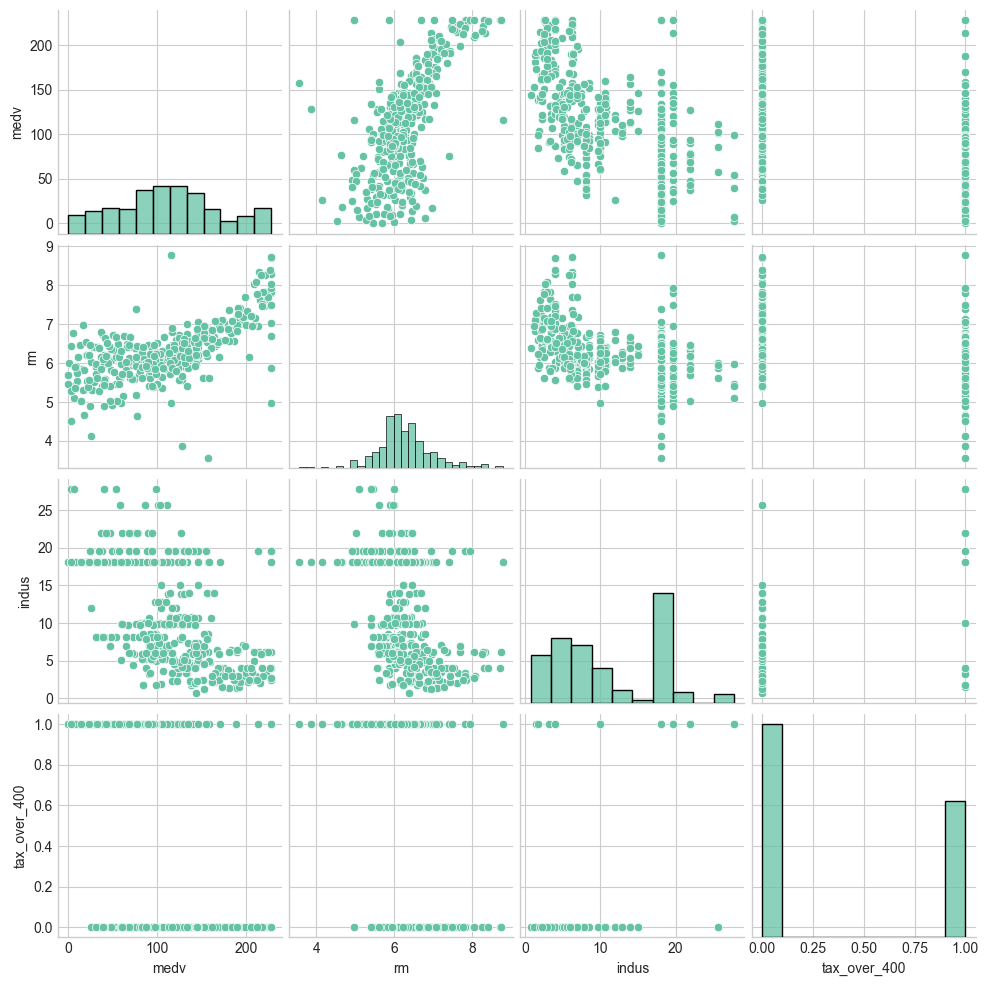

In [35]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['medv', 'rm', 'indus', 'tax_over_400']])
plt.show()

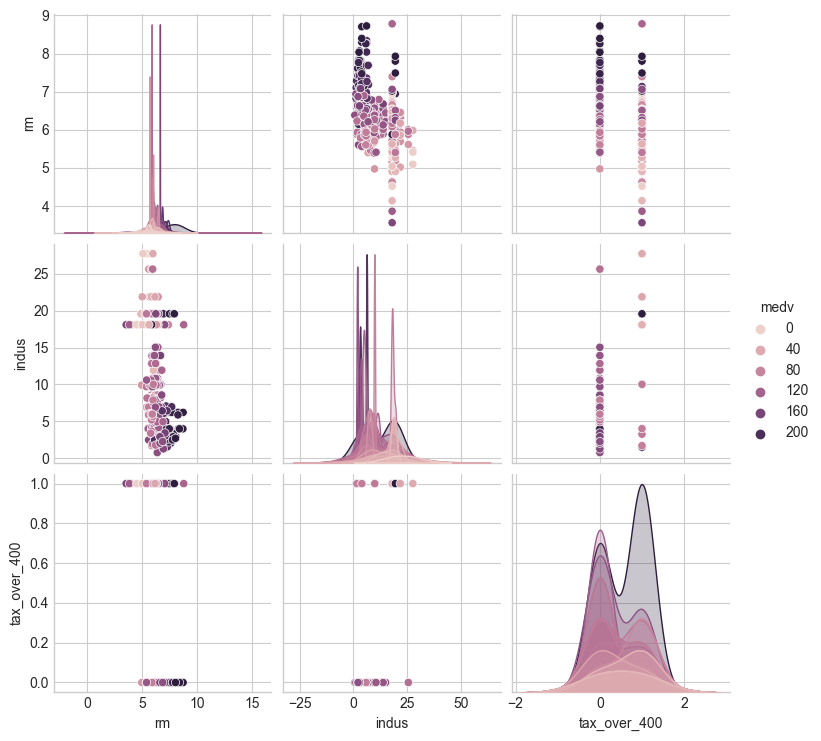

In [36]:
# матричный график разброса с цветом по медианной стоимости домов
sns.pairplot(DF[['medv', 'rm', 'indus', 'tax_over_400']],
            hue='medv')

plt.show()

Теперь покажем цветом на графиках отношение домов к полной ставке налога на имущество на $10000 больше 400.

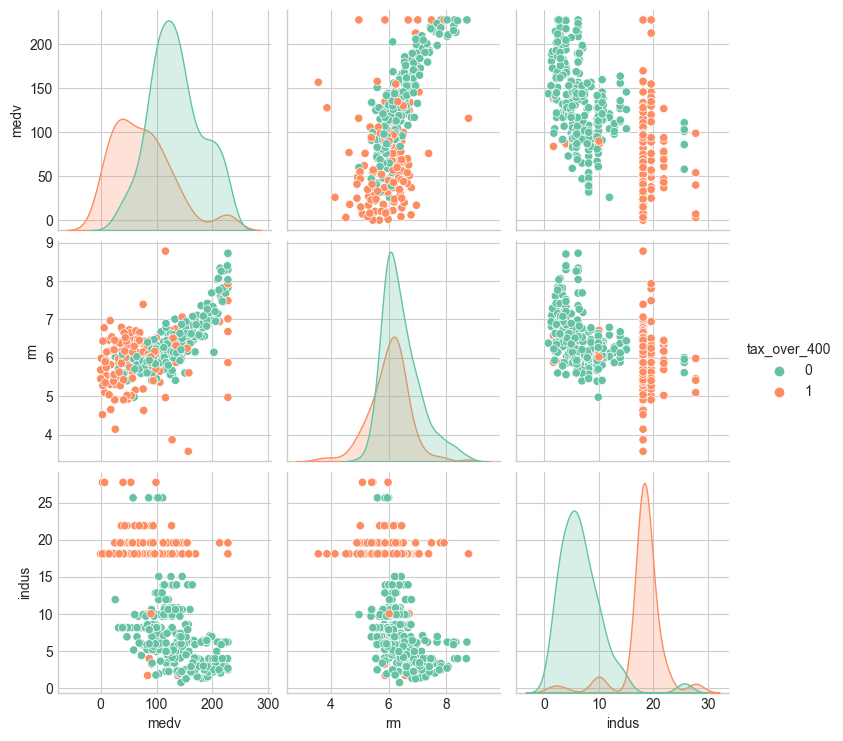

In [37]:
# матричный график разброса с цветом по tax_over_400
sns.pairplot(DF[['medv', 'rm', 'indus', 'tax_over_400']],
            hue='tax_over_400')

plt.show()

Покажем с помощью цвета на графиках среднее количество комнат в доме.

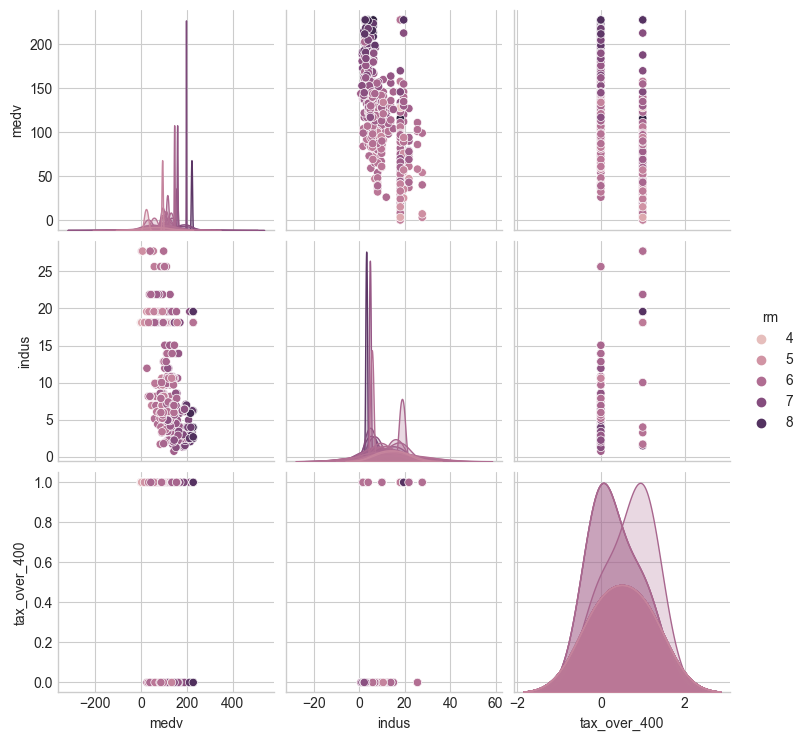

In [38]:
# матричный график разброса с цветом по rm
sns.pairplot(DF[['medv', 'rm', 'indus', 'tax_over_400']], hue='rm')
plt.show()

Нарисуем график отдельно по доле акров, не связанных с розничной торговлей, на город.  

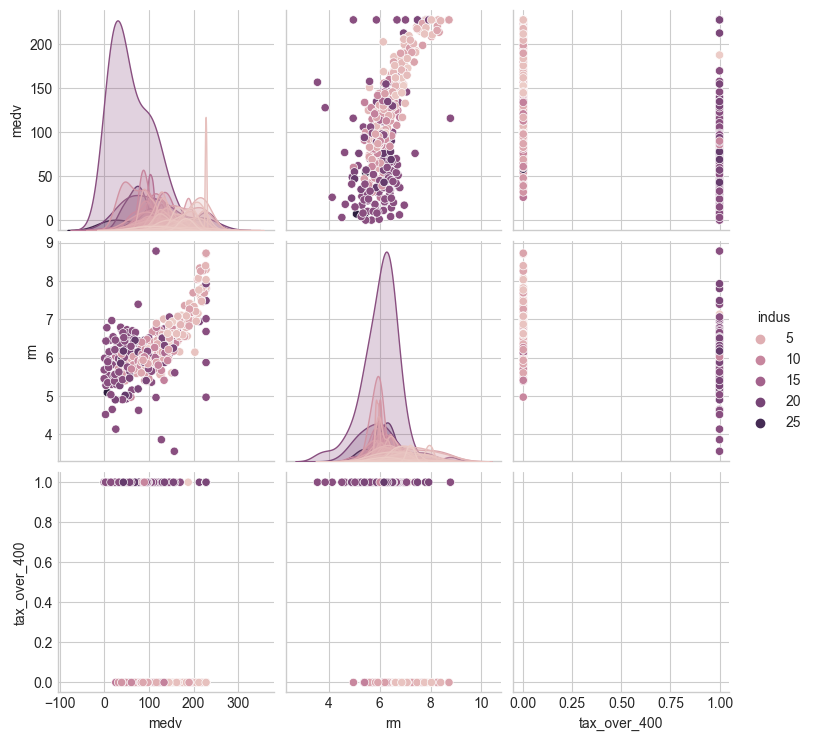

In [39]:
# матричный график разброса с цветом по indus
sns.pairplot(DF[['medv', 'rm', 'indus', 'tax_over_400']], hue='indus')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [40]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'rm', 'indus', 'tax_over_400']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

,medv,rm,indus,tax_over_400
medv,1.00,0.65,-0.56,-0.50
rm,0.65,1.00,-0.38,-0.28
indus,-0.56,-0.38,1.00,0.80
tax_over_400,-0.50,-0.28,0.80,1.00


Посчитаем корреляционные матрицы для полной ставки налога на имущество на $10000 превышающей и не превышающей 400.  

In [41]:
# корреляционная матрица по классу полная ставка налога на имущество на $10000 больше 400
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'rm', 'indus']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,indus
medv,1.00,0.33,-0.15
rm,0.33,1.00,-0.10
indus,-0.15,-0.10,1.00


In [42]:
# корреляционная матрица по классу полная ставка налога на имущество на $10000 400 и меньше
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'rm', 'indus']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,indus
medv,1.00,0.85,-0.42
rm,0.85,1.00,-0.38
indus,-0.42,-0.38,1.00




### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [43]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])

# описательные статистики для непрерывных показателей
DF[['medv', 'log_medv', 'rm', 'indus', 'tax_over_400']].describe()

c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,medv,log_medv,rm,indus,tax_over_400
count,405.000000,405.000000,405.000000,405.000000,405.000000
mean,111.688889,-inf,6.276494,11.153259,0.390123
std,57.564961,NaN,0.707035,6.826609,0.488381
min,0.000000,-inf,3.561000,0.740000,0.000000
25%,72.000000,4.276666,5.888000,5.190000,0.000000
50%,110.000000,4.700480,6.185000,9.690000,0.000000
75%,146.000000,4.983607,6.595000,18.100000,1.000000
max,228.000000,5.429346,8.780000,27.740000,1.000000


Проведём формальные тесты на нормальность.  

In [44]:
# тестируем на нормальность
for col in ['medv', 'log_medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.98, p=0.0000
Распределение не нормально (H0 отклоняется)

log_medv Statistics=nan, p=1.0000
Распределение нормально (H0 не отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

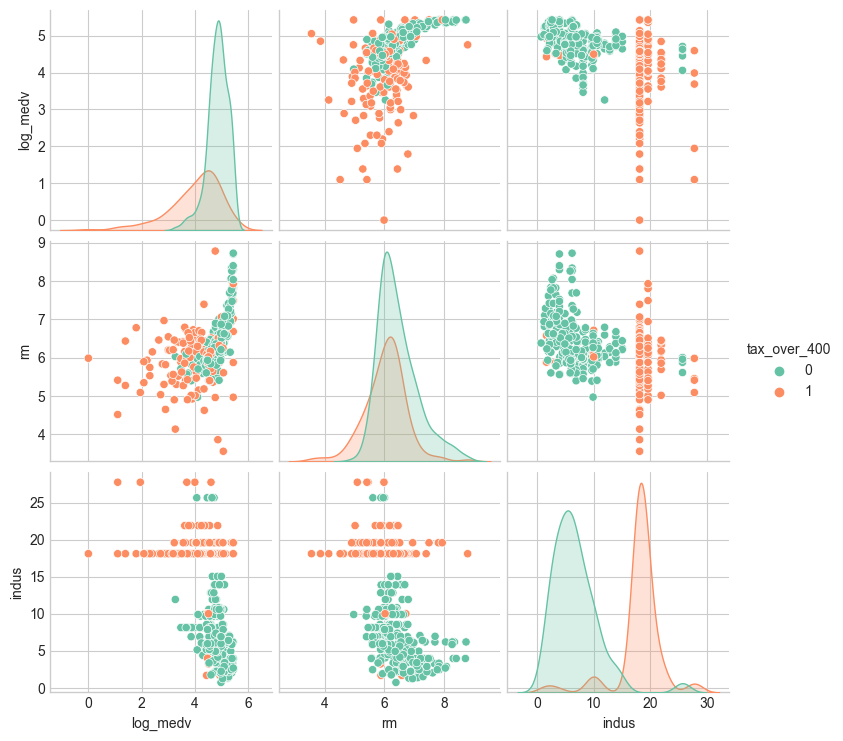

In [45]:
# матричный график разброса с цветом по tax_over_400
sns.pairplot(DF[['log_medv', 'rm', 'indus', 'tax_over_400']], hue='tax_over_400')
plt.show()

In [46]:
# корреляционная матрица по классу полная ставка налога на имущество на $10000 400 и меньше
corr_mat = DF.loc[DF['tax_over_400'] == 0][['log_medv', 'rm', 'indus']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,rm,indus
log_medv,1.00,0.75,-0.39
rm,0.75,1.00,-0.38
indus,-0.39,-0.38,1.00


In [47]:
# корреляционная матрица по классу полная ставка налога на имущество на $10000 больше 400
corr_mat = DF.loc[DF['tax_over_400'] == 1][['log_medv', 'rm', 'indus']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,rm,indus
log_medv,1.00,0.28,-0.18
rm,0.28,1.00,-0.10
indus,-0.18,-0.10,1.00


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot rm + \hat{\beta_3} \cdot indus$
1. `fit_lm_2`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot rm \cdot tax\_over\_400 + \hat{\beta_3} \cdot indus$
1. `fit_lm_3`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus \cdot tax\_over\_400 + \hat{\beta_3} \cdot rm$
1. `fit_lm_4`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus \cdot tax\_over\_400 + \hat{\beta_3} \cdot rm \cdot tax\_over\_400$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_medv}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_medv}$

Кроме того, добавим в сравнение модели зависимости `medv` и `log_medv` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [52]:
# данные для моделей 1, 5
df1 = DF[['medv', 'rm', 'indus', 'tax_over_400']]

# данные для моделей 2, 6
df2 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['rm'], axis=1)

# данные для моделей 3, 7
df3 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df3.loc[:, 'indus_tax_over_400'] = df3.loc[:, 'indus'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['indus'], axis=1)

# данные для моделей 4, 8
df4 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'indus_tax_over_400'] = df4.loc[:, 'indus'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['rm', 'indus'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_medv'], axis=1)

In [53]:
# проверка результатов
df4.head()

,medv,tax_over_400,rm_tax_over_400,indus_tax_over_400
368,228,1,4.970,18.10
105,93,0,0.000,0.00
269,105,0,0.000,0.00
119,91,1,5.731,10.01
351,138,1,6.579,1.69


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `medv` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [54]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [-125.734] 
 объясняющие  ['rm', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 42.398  -1.855 -20.52 ]]


In [55]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([38.54438605])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [56]:
# модель со всеми объясняющими, y_log
from numpy import inf
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
y[y == -inf] = 0.0000001

fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [2.394] 
 объясняющие  ['rm', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 0.402 -0.021 -0.476]]


c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [57]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 49.4,  -2.1, -37.9]])

In [58]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([40.47108263])

In [59]:
print('MSE_train модели для medv меньше MSE_train',
     'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [1.1] раз


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [73]:
# LeaveOneOut CV
loo = LeaveOneOut()


# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = df.medv
    score = cross_val_score(lm, X, y, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 9.08 секунд


In [74]:
df0.shape

(405, 4)

In [75]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    y[y == -inf] = 0.0000001
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Расчёты методом LOOCV заняли 9.25 секунд


Сравним ошибки для моделей на исходных значениях `medv` с ошибками моделей на логарифме.  

In [76]:
scores

[-1523.9655004784815,
 -1523.9655004784815,
 -2201.6263772624598,
 -1566.0954482034667,
 -2401.4878012985855]

In [77]:
[np.around(-x, 2) for x in scores]

[1523.97, 1523.97, 2201.63, 1566.1, 2401.49]

In [78]:
[np.around(-x, 3) for x in scores_log]

[0.45, 0.45, 0.491, 0.449, 0.505]

Определим самые точные модели отдельно на `medv` и на `log_medv`.  

In [79]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 1524.0


In [80]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log',
    'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
    fits[scores_log.index(max(scores_log))],
    ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_3_log :
MSE_loocv = 0.449


Самой точной среди моделей для `medv` оказалась `fit_lm_0`, а среди моделей для `medv_log` – `fit_lm_3_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [81]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['tax_over_400', 'rm', 'indus', ]]
X.loc[:, 'indus_tax_over_400'] = X.loc[:, 'indus'] * X.loc[:, 'tax_over_400']
X = X.drop(['indus'], axis=1)
#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 158097.67


c:\python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- indus_tax_over_400
Feature names seen at fit time, yet now missing:
- indus

  warnings.warn(message, FutureWarning)


In [82]:
# прогноз по fit_lm_log_3
# модель
X = df3.drop(['medv'], axis=1)
y = np.log(df3.medv).values.reshape(-1, 1)
y[y == -inf] = 0 
fit_lm_3_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_3_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_3_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_3_log на отложенных наблюдениях = 1704.03


c:\python310\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- indus
Feature names seen at fit time, yet now missing:
- indus_tax_over_400

  warnings.warn(message, FutureWarning)


In [83]:
np.sqrt(MSE_log) / np.mean(DF_predict[['medv']]) * 100

medv    38.67595
dtype: float64

In [84]:
np.sqrt(MSE) / np.mean(DF_predict[['medv']]) * 100

medv    372.533514
dtype: float64

На выборке для прогноза точнее модель `fit_lm_0`.

In [85]:
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['medv'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [-125.734] 
 объясняющие  ['rm', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 42.398  -1.855 -20.52 ]]


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  